In [773]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import numpy as np
from scipy import spatial

In [774]:
#lint => https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata
movies = pd.read_csv('tmdb_5000_movies.csv')
credits = pd.read_csv('tmdb_5000_credits.csv')

In [775]:
movies = movies.rename(columns={'vote_average': 'rating'})
movies.keys(), credits.keys()

(Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
        'original_title', 'overview', 'popularity', 'production_companies',
        'production_countries', 'release_date', 'revenue', 'runtime',
        'spoken_languages', 'status', 'tagline', 'title', 'rating',
        'vote_count'],
       dtype='object'),
 Index(['movie_id', 'title', 'cast', 'crew'], dtype='object'))

In [776]:
movies['genres'] = movies['genres'].apply(json.loads)
for index,i in zip(movies.index,movies['genres']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name'])) # the key 'name' contains the name of the genre
    movies.loc[index,'genres'] = str(list1)

In [777]:
movies['keywords'] = movies['keywords'].apply(json.loads)
for index,i in zip(movies.index,movies['keywords']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'keywords'] = str(list1)

In [778]:
movies['production_companies'] = movies['production_companies'].apply(json.loads)
for index,i in zip(movies.index,movies['production_companies']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    movies.loc[index,'production_companies'] = str(list1)

In [779]:
credits['cast'] = credits['cast'].apply(json.loads)
for index,i in zip(credits.index,credits['cast']):
    list1 = []
    for j in range(len(i)):
        list1.append((i[j]['name']))
    credits.loc[index,'cast'] = str(list1)

In [780]:
credits['crew'] = credits['crew'].apply(json.loads)
def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
credits['crew'] = credits['crew'].apply(director)
credits.rename(columns={'crew':'director'},inplace=True)

In [781]:
#merging movies and credits df
movies = movies.merge(credits,left_on='id',right_on='movie_id',how='left')

#selecting only important columns
movies = movies[['original_title', 'genres', 'cast', 'director', 'keywords', 'budget', 'revenue', 'vote_count', 'rating']]

In [782]:
#delete rows with no genres, cast, keywords, director and no rating
movies = movies[movies['genres']!='[]']
movies = movies[movies['cast']!='[]']
movies = movies[movies['director']!='[]']
movies = movies[movies['keywords']!='[]']
movies = movies[(movies['rating']!=0)]
movies = movies.dropna()
movies_2 = movies.dropna()

In [783]:
#remove quotes from genres values
movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

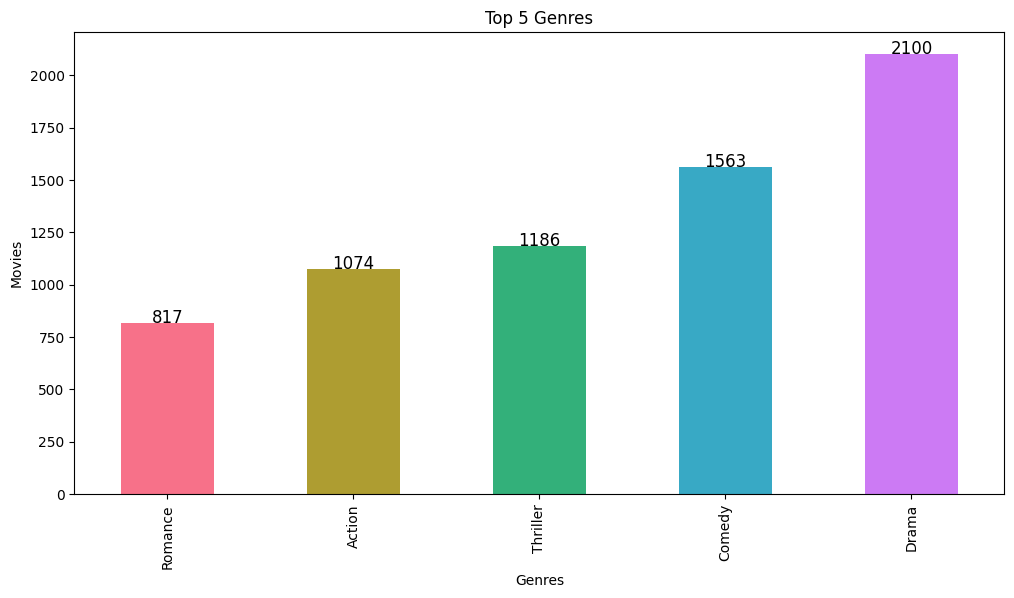

In [784]:
#bar plot of genres
plt.subplots(figsize=(12, 6))
list1 = []

for i in movies['genres']:
    list1.extend(i)

#bar colors
ax = pd.Series(list1).value_counts()[:5].sort_values().plot.bar(width=0.5, color=sns.color_palette('husl', 5))

#annotations
for i, v in enumerate(pd.Series(list1).value_counts()[:5].sort_values().values):
    ax.text(i, v + 0.1, str(v), fontsize=12, color='black', ha='center')

#labels and title
plt.xlabel('Genres')
plt.ylabel('Movies')
plt.title('Top 5 Genres')

plt.show()

In [785]:
#sort genre column
for i,j in zip(movies['genres'],movies.index):
    list2=[]
    list2=i
    list2.sort()
    movies.loc[j,'genres']=str(list2)

movies['genres'] = movies['genres'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['genres'] = movies['genres'].str.split(',')

#create a list of all genres
genreList = []
for index, row in movies.iterrows():
    genres = row["genres"]
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)

In [786]:
#function to one-hot encoding
def binary(list, col_list):
    binaryList = []
    for value in col_list:
        if value in list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    return binaryList

In [787]:
#calling one-encode function
movies['genres_binary'] = movies['genres'].apply(lambda x: binary(x, genreList))

In [788]:
movies['genres_binary'].head()

0    [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: genres_binary, dtype: object

In [789]:
#remove quotes and spaces from cast
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['cast'] = movies['cast'].str.split(',')

In [790]:
movies.head()

,original_title,genres,cast,director,keywords,budget,revenue,vote_count,rating,genres_binary
0,Avatar,"[Action, Adventure, Fantasy, ScienceFiction]","[SamWorthington, ZoeSaldana, SigourneyWeaver, ...",James Cameron,"['culture clash', 'future', 'space war', 'spac...",237000000,2787965087,11800,7.2,"[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Pirates of the Caribbean: At World's End,"[Action, Adventure, Fantasy]","[JohnnyDepp, OrlandoBloom, KeiraKnightley, Ste...",Gore Verbinski,"['ocean', 'drug abuse', 'exotic island', 'east...",300000000,961000000,4500,6.9,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Spectre,"[Action, Adventure, Crime]","[DanielCraig, ChristophWaltz, LéaSeydoux, Ralp...",Sam Mendes,"['spy', 'based on novel', 'secret agent', 'seq...",245000000,880674609,4466,6.3,"[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]","[ChristianBale, MichaelCaine, GaryOldman, Anne...",Christopher Nolan,"['dc comics', 'crime fighter', 'terrorist', 's...",250000000,1084939099,9106,7.6,"[1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,John Carter,"[Action, Adventure, ScienceFiction]","[TaylorKitsch, LynnCollins, SamanthaMorton, Wi...",Andrew Stanton,"['based on novel', 'mars', 'medallion', 'space...",260000000,284139100,2124,6.1,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


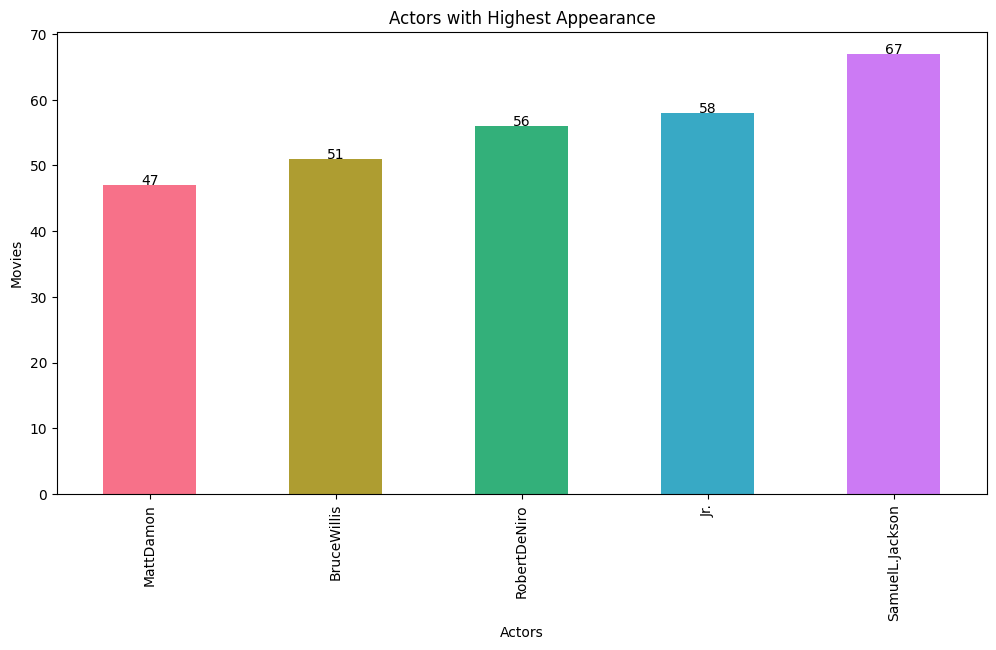

In [791]:
#top actors bar chart
plt.subplots(figsize=(12, 6))
list1 = []

for i in movies['cast']:
    list1.extend(i)

# Use different colors from the 'husl' color palette
ax = pd.Series(list1).value_counts()[:5].sort_values().plot.bar(width=0.5, color=sns.color_palette('husl', 5))

# Add annotations
for i, v in enumerate(pd.Series(list1).value_counts()[:5].sort_values().values):
    ax.text(i, v + 0.1, str(v), fontsize=10, color='black', ha='center')

# Set labels and title
plt.xlabel('Actors')
plt.ylabel('Movies')
plt.title('Actors with Highest Appearance')

plt.show()

In [792]:
#getting first 5 actors in each movie
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i[:3]
    movies.loc[j,'cast'] = str(list2)
movies['cast'] = movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['cast'] = movies['cast'].str.split(',')

#sorting
for i,j in zip(movies['cast'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'cast'] = str(list2)
movies['cast']=movies['cast'].str.strip('[]').str.replace(' ','').str.replace("'",'')

#create a list of top actors
castList = []
for index, row in movies.iterrows():
    cast = row["cast"]
    for i in cast:
        if i not in castList:
            castList.append(i)

#calling one-hot encoding function
movies['cast_binary'] = movies['cast'].apply(lambda x: binary(x, castList))

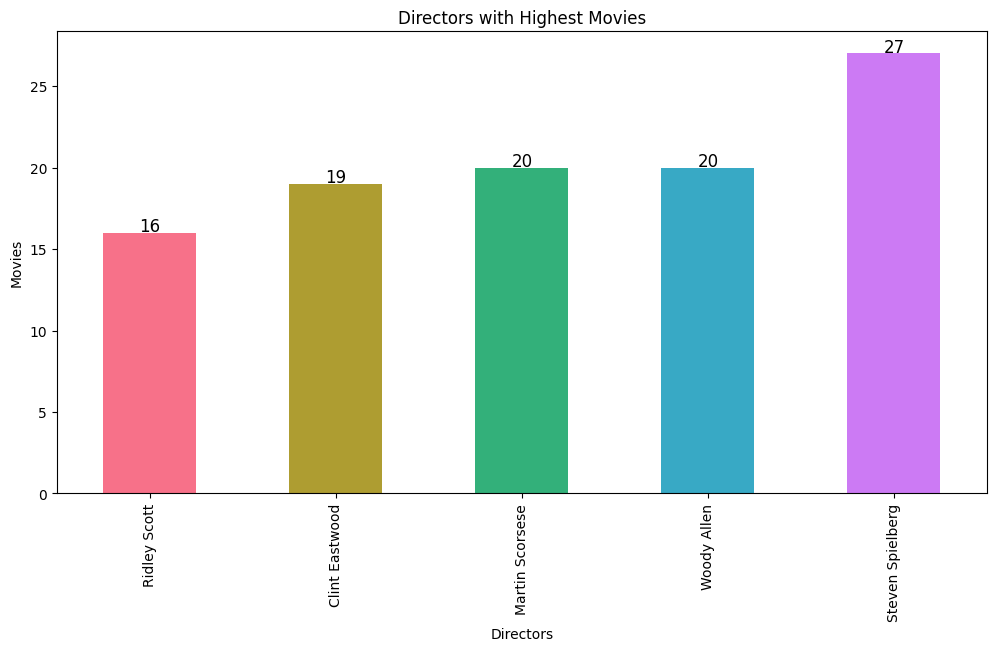

In [793]:
#directors chart
plt.subplots(figsize=(12, 6))

# Filter out rows where director is an empty string
filtered_directors = movies[movies['director'] != '']

ax = filtered_directors['director'].value_counts()[:5].sort_values().plot.bar(width=0.5, color=sns.color_palette('husl', 5))

# Add annotations
for i, v in enumerate(filtered_directors['director'].value_counts()[:5].sort_values().values):
    ax.text(i, v + 0.1, str(v), fontsize=12, color='black', ha='center')

# Set labels and title
plt.xlabel('Directors')
plt.ylabel('Movies')
plt.title('Directors with Highest Movies')

plt.show()

In [794]:
#list of directors
def xstr(s):
    if s is None:
        return ''
    return str(s)
movies['director'] = movies['director'].apply(xstr)

directorList=[]
for i in movies['director']:
    if i not in directorList:
        directorList.append(i)

#calling one-hot encode function
movies['director_binary'] = movies['director'].apply(lambda x: binary(x, directorList))

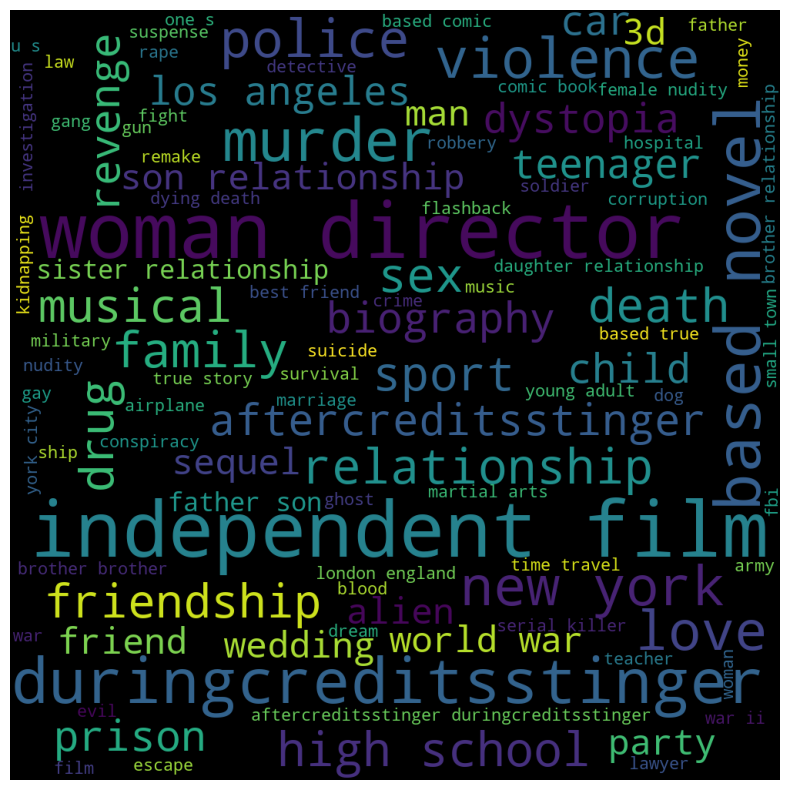

In [795]:
#plotting a word cloud
plt.subplots(figsize=(12,12))
stop_words = set(stopwords.words('english'))
stop_words.update(',',';','!','?','.','(',')','$','#','+',':','...',' ','')

words=movies['keywords'].dropna().apply(nltk.word_tokenize)

word=[]
for i in words:
    word.extend(i)
word=pd.Series(word)
word=([i for i in word.str.lower() if i not in stop_words])
wc = WordCloud(background_color="black", max_words=100, stopwords=STOPWORDS, max_font_size= 100,width=1000,height=1000)
wc.generate(" ".join(word))
plt.imshow(wc)
plt.axis('off')
fig=plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [796]:
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'').str.replace('"','')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')
for i,j in zip(movies['keywords'],movies.index):
    list2 = []
    list2 = i
    list2.sort()
    movies.loc[j,'keywords'] = str(list2)
movies['keywords'] = movies['keywords'].str.strip('[]').str.replace(' ','').str.replace("'",'')
movies['keywords'] = movies['keywords'].str.split(',')

words_list = []
for index, row in movies.iterrows():
    word_rows = row["keywords"]
    for wr in word_rows:
        if wr not in words_list:
            words_list.append(wr)

#calling one-hot encode function
movies['words_binary'] = movies['keywords'].apply(lambda x: binary(x, words_list))

In [797]:
movies.keys()

Index(['original_title', 'genres', 'cast', 'director', 'keywords', 'budget',
       'revenue', 'vote_count', 'rating', 'genres_binary', 'cast_binary',
       'director_binary', 'words_binary'],
      dtype='object')

In [800]:
movies_2.head(1)

,original_title,budget,revenue,vote_count,rating,genres_'Action',"genres_'Action', 'Adventure'","genres_'Action', 'Adventure', 'Animation', 'Comedy', 'Family'","genres_'Action', 'Adventure', 'Animation', 'Comedy', 'Family', 'Fantasy', 'Science Fiction'","genres_'Action', 'Adventure', 'Animation', 'Family'",...,"keywords_'yacht', 'movie in movie', 'scuba diving', 'piranha', 'spring break', 'man eaten by monster', '3d'","keywords_'yacht', 'sailor', 'storm at sea', 'unconsciousness', 'life raft', 'container', 'emergency', 'distress', 'very little dialogue'","keywords_'yakuza', 'los angeles', 'samurai sword'","keywords_'yakuza', 'marine', 'fighting'","keywords_'yorkshire', 'love', 'friends'","keywords_'yuppie', 'daughter', 'loss of wife'",keywords_'zombie',"keywords_'zombie', 'found footage'",keywords_'zoo',"keywords_'绝地奶霸', '卧底肥妈', 'big爆任务', '超级妈妈'"
0,Avatar,237000000,2787965087,11800,7.2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [799]:
movies_2['genres'] = movies_2['genres'].str.strip('[]')
movies_2['cast'] = movies_2['cast'].str.strip('[]')
movies_2['director'] = movies_2['director'].str.strip('[]')
movies_2['keywords'] = movies_2['keywords'].str.strip('[]')

movies_2 = pd.get_dummies(movies_2, columns=['genres', 'cast', 'director', 'keywords'])

In [765]:
def distance(movie_1, movie_2):
    genre_distance = spatial.distance.cosine(movies.iloc[movie_1]['genres_binary'], movies.iloc[movie_2]['genres_binary'])
    cast_distance = spatial.distance.cosine(movies.iloc[movie_1]['cast_binary'], movies.iloc[movie_2]['cast_binary'])
    director_distance = spatial.distance.cosine(movies.iloc[movie_1]['director_binary'], movies.iloc[movie_2]['director_binary'])
    words_distance = spatial.distance.cosine(movies.iloc[movie_1]['words_binary'], movies.iloc[movie_2]['words_binary'])
    return genre_distance + cast_distance + director_distance + words_distance

In [766]:
distance(14,25)
#1,12 and 35,36
#32,#35 and 14,25

3.35

In [832]:
m = movies_2.drop(columns = 'original_title', axis=1)
m = m.dropna()

In [833]:
y = m['rating']
X = m.drop(columns = ['rating'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [834]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(X_train)

NearestNeighbors(algorithm='brute', metric='cosine')

In [852]:
def print_similar_movies(query_index) :
    # Get the top 10 nearest neighbors for the movie
    distances, indices = model_knn.kneighbors(X.iloc[query_index, :].values.reshape(1, -1), n_neighbors = 11)
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for {0}:\n'.format(X.index[query_index]))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, X.index[indices.flatten()[i]], distances.flatten()[i]))

c:\Users\frank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


Recommendations for 0:

1: 3295, with distance of 8.178058785723863e-09:
2: 2545, with distance of 2.6574227929287986e-08:
3: 483, with distance of 3.326596886843447e-08:
4: 3593, with distance of 3.822304583955827e-08:
5: 2407, with distance of 1.7530878448912546e-07:
6: 752, with distance of 1.847414115019319e-07:
7: 2868, with distance of 2.2968201640605201e-07:
8: 1497, with distance of 4.2099864983047297e-07:
9: 2630, with distance of 4.893249549997591e-07:
10: 140, with distance of 5.937151587032119e-07:


In [ ]:
print_similar_movies(0)